# Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as plt

In [3]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from statsmodels.tsa.ar_model import AR

In [5]:
from sklearn.metrics import mean_squared_error as mse

# Functions

In [6]:
def clean_data():
    
    global db1
    db1 = db1[(db1.num_infections > 0)].reset_index()
    db1 = db1.drop(columns = ['index'], axis = 1)
    
    db1['date'] = pd.to_datetime(db1.date)
    
   
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Comunidad Valenciana' if x == 'Valenciana, Comunidad' else x)
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Comunidad de Madrid' if x == 'Madrid, Comunidad de' else x)
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Región de de Murcia' if x == 'Murcia, Región de' else x)
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Comunidad Foral de Navarra' if x == 'Navarra, Comunidad Foral de' else x)
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Principado de Asturias' if x == 'Asturias, Principado de' else x)
    
    
    db1['province'] = db1.province.apply(lambda x: 'Alicante' if x == 'Alicante/Alacant' else x)
    db1['province'] = db1.province.apply(lambda x: 'Castellón' if x == 'Castellón/Castelló' else x)
    db1['province'] = db1.province.apply(lambda x: 'Araba' if x == 'Araba/Álava' else x)
    
    db1['sex'] = db1.sex.apply(lambda x: 'UKNOWN' if x == 'NC' else x)
    
    db1['age_interval'] = db1.age_interval.apply(lambda x: 'UKNOWN' if x == 'NC' else x)

In [7]:
def cumulative(dataframe):
    
    cumu_num_infections = dataframe.num_infections.cumsum()
    cumu_num_hosp = dataframe.num_hosp.cumsum()
    cumu_num_uci = dataframe.num_uci.cumsum()
    cumu_num_dead = dataframe.num_dead.cumsum()

    cumulative = pd.DataFrame({'cumu_num_infections': cumu_num_infections, 'cumu_num_hosp': cumu_num_hosp, 
                               'cumu_num_uci': cumu_num_uci, 'cumu_num_dead': cumu_num_dead})
    dataframe = pd.concat([dataframe, cumulative], axis = 1)
    return dataframe

In [8]:
def freq_rel(dataframe):
    
    dataframe['Number of infection (%)'] = [round(i/ dataframe['num_infections'].sum(),3)*100 for i in dataframe['num_infections']]
    dataframe['Number of hospitalisation (%)'] = [round(i/ dataframe['num_hosp'].sum(),3)*100 for i in dataframe['num_hosp']]
    dataframe['Number of Intensive Care Unit (%)'] = [round(i/ dataframe['num_uci'].sum(),3)*100 for i in dataframe['num_uci']]
    dataframe['Number of deaths (%)'] = [round(i/ dataframe['num_dead'].sum(),3)*100 for i in dataframe['num_dead']]

In [9]:
def organise(column):
    
    name = db1.groupby(column).sum()
    freq_rel(name)
    
    return name

# Data base

In [10]:
db1 =pd.read_csv('covid-19-sample.csv') 

In [11]:
clean_data()

In [12]:
db1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299683 entries, 0 to 299682
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               299683 non-null  datetime64[ns]
 1   autonomous_region  299683 non-null  object        
 2   province           299683 non-null  object        
 3   sex                299683 non-null  object        
 4   age_interval       299683 non-null  object        
 5   num_infections     299683 non-null  int64         
 6   num_hosp           299683 non-null  int64         
 7   num_uci            299683 non-null  int64         
 8   num_dead           299683 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 20.6+ MB


In [13]:
bydate = organise('date')

In [14]:
bydate


,num_infections,num_hosp,num_uci,num_dead,Number of infection (%),Number of hospitalisation (%),Number of Intensive Care Unit (%),Number of deaths (%)
date,,,,,,,,
2020-01-18,1,1,0,0,0.0,0.0,0.0,0.0
2020-01-31,1,0,0,0,0.0,0.0,0.0,0.0
2020-02-09,1,1,0,0,0.0,0.0,0.0,0.0
2020-02-12,3,0,0,0,0.0,0.0,0.0,0.0
2020-02-21,1,0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-06-04,4381,172,13,17,0.1,0.0,0.0,0.0
2021-06-05,2352,132,11,13,0.1,0.0,0.0,0.0
2021-06-06,1648,117,8,7,0.0,0.0,0.0,0.0


In [15]:
infections = pd.DataFrame(bydate.num_infections, columns = ['num_infections'])

In [16]:
infections

,num_infections
date,
2020-01-18,1
2020-01-31,1
2020-02-09,1
2020-02-12,3
2020-02-21,1
...,...
2021-06-04,4381
2021-06-05,2352
2021-06-06,1648


# ARMA

In [17]:
from statsmodels.tsa.arima_model import ARMA

## Number of infections

In [18]:
import warnings
warnings.simplefilter('ignore')
res = []
for i in range(1, 20):
    for j in range(1,10): 
        for k in range(1,7):
            train, test = infections[:-i], infections[-i:]
            model=ARMA(train, order=(j, k)).fit(disp=False)
            pred=model.predict(len(train), len(infections)-1)
            test['predictions'] = list(pred)
            test['diff'] = abs(test['num_infections'] - test['predictions'])
            res.append(((i, j, k), mse(test['num_infections'], pred)**0.5))
            #print(mse(test['num_infections'], pred)**0.5, '\nerror mae:', test['diff'].sum()/len(test))

In [19]:
errors = []
for i, e in enumerate(res):
    errors.append(res[i][1])

sorted(errors)


[175.1251490650966,
 291.5368274999887,
 301.3678269008369,
 321.55580439571077,
 339.617356590942,
 343.50590498809606,
 360.1175524531394,
 369.21741460634263,
 389.0486783534041,
 396.7148158427318,
 399.05052579570804,
 407.648458570438,
 424.09449571119166,
 434.27215316454334,
 454.02206857045076,
 475.38128158246195,
 492.3831711298872,
 522.0832401316222,
 533.1969818796334,
 533.8501427880019,
 554.0444368367873,
 563.415487759831,
 563.6767477199,
 575.3795305090079,
 595.7511840141959,
 598.2162323882669,
 603.4075442231842,
 636.3938836552118,
 643.9509686966738,
 647.8299200277025,
 649.6371297164663,
 659.4210379560768,
 675.5393115335299,
 675.8814626275007,
 681.9046858477961,
 685.4599400136458,
 692.7291557909439,
 693.927237236707,
 694.1382485897952,
 694.3675452709027,
 708.7539246931951,
 713.0286578374414,
 713.1119679590869,
 714.4238164362273,
 717.4798523967463,
 720.1988310873402,
 722.0436158939855,
 722.3297807038966,
 722.9019910404091,
 723.8339917992594,

In [20]:
best = []
for j, k in enumerate(errors):
    if k == min(errors):
        best.append(res[j])
best

[((1, 1, 6), 175.1251490650966)]

## Number of hospitalisation

In [25]:
hosp = pd.DataFrame(bydate.num_hosp, columns = ['num_hosp'])

In [26]:
hosp

,num_hosp
date,
2020-01-18,1
2020-01-31,0
2020-02-09,1
2020-02-12,0
2020-02-21,0
...,...
2021-06-04,172
2021-06-05,132
2021-06-06,117


In [27]:
res = []
for i in range(1, 20):
    for j in range(1,10): 
        for k in range(1,7):
            train, test = hosp[:-i], hosp[-i:]
            model=ARMA(train, order=(j, k)).fit(disp=False)
            pred=model.predict(len(train), len(hosp)-1)
            res.append(((i, j, k), mse(test['num_hosp'], pred)**0.5))

In [28]:
errors = []
for i, e in enumerate(res):
    errors.append(res[i][1])

In [29]:
best = []
for j, k in enumerate(errors):
    if k == min(errors):
        best.append(res[j])
best

[((3, 5, 4), 24.825426209801815)]

## Number of Intensive Care Unites

In [30]:
uci = pd.DataFrame(bydate.num_uci, columns = ['num_uci'])

In [31]:
uci

,num_uci
date,
2020-01-18,0
2020-01-31,0
2020-02-09,0
2020-02-12,0
2020-02-21,0
...,...
2021-06-04,13
2021-06-05,11
2021-06-06,8


In [ ]:
res = []
for i in range(1, 20):
    for j in range(1,10): 
        for k in range(1,7):
            train, test = uci[:-i], uci[-i:]
            model=ARMA(train, order=(j, k)).fit(disp=False)
            pred=model.predict(len(train), len(uci)-1)
            res.append(((i, j, k), mse(test['num_uci'], pred)**0.5))
            #print(mse(test['num_infections'], pred)**0.5, '\nerror mae:', test['diff'].sum()/len(test))

In [ ]:
errors = []
for i, e in enumerate(res):
    errors.append(res[i][1])

In [ ]:
best = []
for j, k in enumerate(errors):
    if k == min(errors):
        best.append(res[j])
best

## Number of deaths

In [ ]:
dead = pd.DataFrame(bydate.num_dead, columns = ['num_dead'])

In [ ]:
res = []
for i in range(1, 20):
    for j in range(1,10): 
        for k in range(1,7):
            train, test = dead[:-i], dead[-i:]
            model=ARMA(train, order=(j, k)).fit(disp=False)
            pred=model.predict(len(train), len(infections)-1)
            res.append(((i, j, k), mse(test['num_dead'], pred)**0.5))
            #print(mse(test['num_infections'], pred)**0.5, '\nerror mae:', test['diff'].sum()/len(test))

In [ ]:
errors = []
for i, e in enumerate(res):
    errors.append(res[i][1])

In [ ]:
best = []
for j, k in enumerate(errors):
    if k == min(errors):
        best.append(res[j])
best

# FB Prophet

In [ ]:
from fbprophet import Prophet
plt.style.use('fivethirtyeight')

In [ ]:
def time_features(df):
    
    df=df.copy()
    
    df['date']=df.index
    
    df['hour']=df.date.dt.hour
    df['day_of_week']=df.date.dt.dayofweek
    df['quarter']=df.date.dt.quarter
    df['month']=df.date.dt.month
    df['year']=df.date.dt.year
    df['day_of_year']=df.date.dt.dayofyear
    df['day_of_month']=df.date.dt.day
    df['week_of_year']=df.date.dt.weekofyear
    
    return df

In [ ]:
train, test = bydate.num_infections[:-45], bydate.num_infections[-45:]
train=train.reset_index().rename(columns={'date':'ds', 'num_infections':'y'})
test=test.reset_index().rename(columns={'date':'ds', 'num_infections':'y'})

In [ ]:
%%time

model=Prophet().fit(train)

pred=model.predict(test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2.71 s, sys: 176 ms, total: 2.88 s
Wall time: 2.86 s


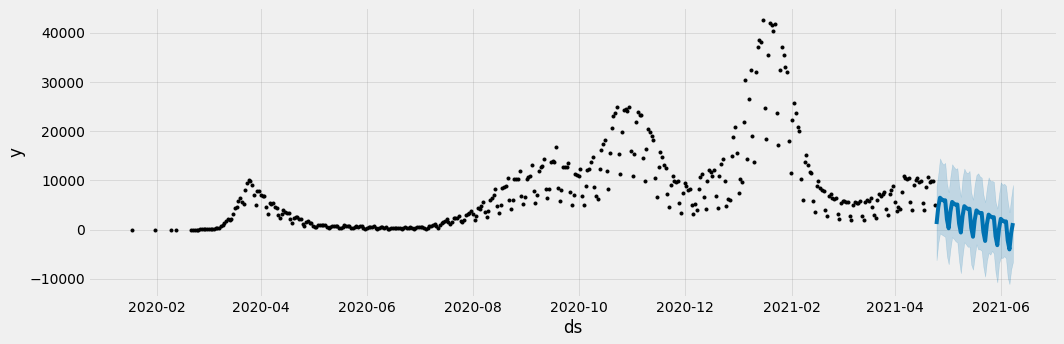

In [ ]:
f, ax=plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig=model.plot(pred, ax=ax)

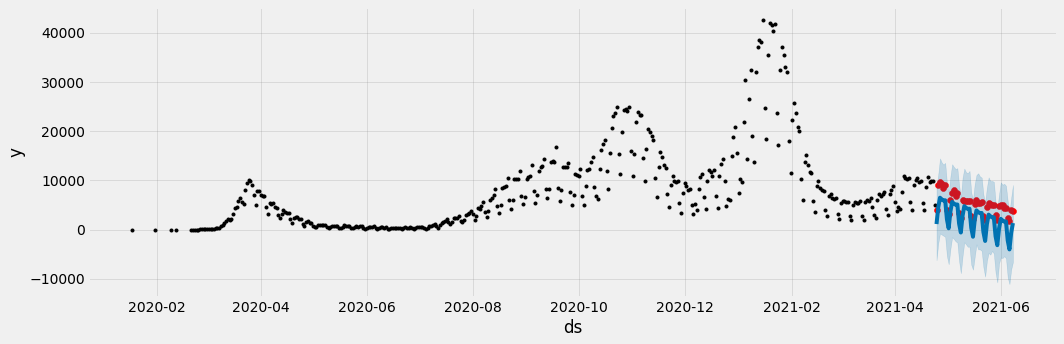

In [ ]:
f, ax=plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.ds, test.y, color='r')
fig=model.plot(pred, ax=ax)

In [ ]:
mse(test.y, pred.yhat)**0.5

3087.507960889105

In [ ]:
out = []
for i in range(1, 100):
  train, test = bydate.num_infections[:-i], bydate.num_infections[-i:]
  train=train.reset_index().rename(columns={'date':'ds', 'num_infections':'y'})
  test=test.reset_index().rename(columns={'date':'ds', 'num_infections':'y'})
  model=Prophet().fit(train)
  pred=model.predict(test)
  out.append((i, mse(test.y, pred.yhat)**0.5))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
sorted(out)

[(1, 456.23301121534223),
 (2, 1160.7845621709432),
 (3, 1744.3093301873557),
 (4, 1918.1365258470846),
 (5, 1650.0109693750408),
 (6, 1312.5268127416825),
 (7, 1466.3599347069037),
 (8, 1396.2484501197623),
 (9, 1367.6055027720467),
 (10, 1686.7555682067343),
 (11, 1905.8476949125027),
 (12, 1554.6973320253092),
 (13, 1889.0705933315355),
 (14, 1367.5390154557683),
 (15, 1382.8407363870035),
 (16, 1296.6121747433249),
 (17, 1489.7509983378736),
 (18, 1477.235761287332),
 (19, 1431.0808431601638),
 (20, 1549.1054694456693),
 (21, 1485.0356362007437),
 (22, 1441.0804278557632),
 (23, 1478.9054559718652),
 (24, 1394.0291535589554),
 (25, 1348.301599986152),
 (26, 1444.038115288237),
 (27, 1168.2056980847447),
 (28, 1382.3967734715693),
 (29, 1352.7116667327036),
 (30, 1202.655583804378),
 (31, 1439.2171788230216),
 (32, 1255.3443537151318),
 (33, 1369.456210944927),
 (34, 1485.1332678522942),
 (35, 1607.295370273326),
 (36, 1495.0642302679219),
 (37, 1272.6934064464033),
 (38, 1053.04238

In [ ]:
! pip install h2o

In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8tqbhzmz
  JVM stdout: /tmp/tmp8tqbhzmz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8tqbhzmz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,"28 days, 18 hours and 12 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_352ej3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.174 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
infections = infections.reset_index()

In [ ]:
infections = infections.to_csv('infections.csv', index=False)

In [ ]:
df=h2o.import_file('/content/infections.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
df

date,num_infections
2020-01-18 00:00:00,1
2020-01-31 00:00:00,1
2020-02-09 00:00:00,1
2020-02-12 00:00:00,3
2020-02-21 00:00:00,1
2020-02-22 00:00:00,1
2020-02-23 00:00:00,2
2020-02-24 00:00:00,2
2020-02-25 00:00:00,1
2020-02-26 00:00:00,7


In [ ]:
X=df.columns
y='num_infections'
X.remove(y)

In [ ]:
df[y]=df[y].asfactor()

In [ ]:
aml=H2OAutoML(max_models=3, seed=1)

aml.train(x=X, y=y, training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%

12:14:58.810: StackedEnsemble_AllModels_AutoML_20210617_121316 [StackedEnsemble all (built using all AutoML models)] failed: java.lang.RuntimeException: java.lang.ArrayIndexOutOfBoundsException: Index 1393 out of bounds for length 1393



In [ ]:
lb=aml.leaderboard

lb.head(rows=lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
XGBoost_1_AutoML_20210617_121316,0.997845,7.57046,0.999321,0.998643,nan,nan
XGBoost_3_AutoML_20210617_121316,0.997845,7.68553,0.998116,0.996236,nan,nan
XGBoost_2_AutoML_20210617_121316,0.997845,7.53567,0.999306,0.998612,nan,nan


In [ ]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20210617_121316


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.995435760748352
RMSE: 0.9977152703794565
LogLoss: 6.134358727474989
Mean Per-Class Error: 0.9978448275862069
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,1,2,3,7,19,23,38,71,84,99,122,142,165,175,187,188,206,227,240,250,256,261,273,274,285,289,292,305,314,332,333,336,339,340,341,344,346,356,358,369,...,20719,20920,20931,21761,21825,22244,23160,23286,23367,23588,23658,23718,23857,24110,24237,24469,24776,24898,24905,25767,26481,30364,32000,32007,32377,32493,32960,35391,35413,37079,37171,38043,38548,40447,41547,41806,42000,42547,Error,Rate
0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 / 6
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2 / 2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2 / 2
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2 / 2
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1



See the whole table with table.as_data_frame()

Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.012552
1,2,0.016736
2,3,0.020921
3,4,0.025105
4,5,0.029289
5,6,0.033473
6,7,0.037657
7,8,0.041841
8,9,0.046025
9,10,0.050209



ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.9986427734190231
RMSE: 0.9993211562951237
LogLoss: 7.5704559607072
Mean Per-Class Error: 0.9978448275862069
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,1,2,3,7,19,23,38,71,84,99,122,142,165,175,187,188,206,227,240,250,256,261,273,274,285,289,292,305,314,332,333,336,339,340,341,344,346,356,358,369,...,20719,20920,20931,21761,21825,22244,23160,23286,23367,23588,23658,23718,23857,24110,24237,24469,24776,24898,24905,25767,26481,30364,32000,32007,32377,32493,32960,35391,35413,37079,37171,38043,38548,40447,41547,41806,42000,42547,Error,Rate
0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 / 6
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2 / 2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2 / 2
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1
8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2 / 2
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1 / 1



See the whole table with table.as_data_frame()

Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.012552
1,2,0.012552
2,3,0.012552
3,4,0.012552
4,5,0.012552
5,6,0.012552
6,7,0.012552
7,8,0.012552
8,9,0.012552
9,10,0.012552



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.01254386,0.004634281,0.020833334,0.010416667,0.010416667,0.010526316,0.010526316
1,auc,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,err,0.98745614,0.004634281,0.9791667,0.9895833,0.9895833,0.9894737,0.9894737
3,err_count,94.4,0.5477226,94.0,95.0,95.0,94.0,94.0
4,logloss,7.5705705,0.0339284,7.549212,7.569175,7.5385995,7.5694127,7.6264534
5,max_per_class_error,1.0,0.0,1.0,1.0,1.0,1.0,1.0
6,mean_per_class_accuracy,0.79698277,0.0018031466,0.79741377,0.79525864,0.79525864,0.79741377,0.79956895
7,mean_per_class_error,0.20301723,0.0018031466,0.2025862,0.20474137,0.20474137,0.2025862,0.20043103
8,mse,0.9986431,1.0519111E-4,0.99851,0.9986698,0.99860644,0.99863005,0.998799
9,pr_auc,NaN,0.0,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-06-17 12:13:45,29.175 sec,0.0,0.997845,6.139885,0.997908,NaN,NaN
1,,2021-06-17 12:13:46,29.953 sec,5.0,0.997787,6.133894,0.987448,NaN,NaN
2,,2021-06-17 12:13:47,30.638 sec,10.0,0.997736,6.133308,0.987448,NaN,NaN
3,,2021-06-17 12:13:47,31.293 sec,15.0,0.997723,6.134796,0.987448,NaN,NaN
4,,2021-06-17 12:13:49,32.392 sec,20.0,0.997720,6.135973,0.987448,NaN,NaN
5,,2021-06-17 12:13:50,33.618 sec,25.0,0.997738,6.136498,0.987448,NaN,NaN
6,,2021-06-17 12:13:51,34.678 sec,30.0,0.997715,6.134359,0.987448,NaN,NaN


In [ ]:
pred=aml.leader.predict(X)

pred

ValueError: ignored

In [47]:
y

'num_infections'

In [48]:
X

['date']